# Week 8 Tutorial
This notebook serves as support material to solve two questions in **Chapter 8 - First-Order Logic**, i.e., 8.24 and 8.27. A program illustrating the resolution inference algorithm for first-order logic is also provided in this tutorial. 

## 8.24 Represent the following sentences in first-order logic, using a consistent vocabulary (which you must define):

**a**. Some students took French in spring 2001.

**b**. Every student who takes French passes it.

**c**. Only one student took Greek in spring 2001.

**d**. The best score in Greek is always higher than the best score in French.

**e**. Every person who buys a policy is smart.

**f**. No person buys an expensive policy.

**g**. There is an agent who sells policies only to people who are not insured.


**Answer**:

In this exercise, it is best not to worry about details of tense and larger concerns with consistent ontologies and so on. The main point is to make sure we understand connectives and quantifiers and the use of predicates, functions, constants, and equality. Let the basic vocabulary be as follows:

$Takes(x,c,s)$: student $x$ takes course $c$ in semester $s$;

$Passes(x,c,s)$: student $x$ passes course $c$ in semester $s$;

$Score(x,c,s)$: the score obtained by student $x$ in course $c$ in semester $s$;

$x > y$: $x$ is greater than $y$;

$F and G$: specific French and Greek courses (one could also interpret these sentences as referring
to $any$ such course, in which case one could use a predicate $Subject(c,f)$ meaning that the subject of course $c$ is field $f$;

$Buys(x,y,z)$: $x$ buys $y$ from $z$ (using a binary predicate with unspecified seller is OK but less felicitous);

$Sells(x,y,z)$: $x$ sells $y$ to $z$;

$Student(x), Person(x), Expensive(x), Agent(x), Insured(x), Smart(x), Policy(x)$: predicates satisfied by members of the corresponding categories.

**a**. Some students took French in spring 2001.

$\exists x \; Student(x)\wedge Takes(x, F, Spring2011)$.

**b**. Every student who takes French passes it.

$\forall x, Student(x) \wedge Takes(x, F, s) \Rightarrow Passes(x, F, s)$.

**c**. Only one student took Greek in spring 2001.

$\exists x \; Student(x) \wedge Takes(x, G, Spring2011) \wedge \forall y \; y\neq x \Rightarrow \neg Takes(y, G, Spring2011) $.

**d**. The best score in Greek is always higher than the best score in French.

$\forall s \; \exists x \; \forall y \; Score(x, G, s) > Score(y, F, s)$.

**e**. Every person who buys a policy is smart.

$\forall x \; Person(x) \wedge (\exists y,z\; Policy(y)\wedge Buys(x,y,z)) \Rightarrow Smart(x)$.

**f**. No person buys an expensive policy.

$\forall x, y, z \; Person(x) \wedge Policy(y) \wedge Expensive(y) \Rightarrow \neg Buys(x,y,z)$.

**g**. There is an agent who sells policies only to people who are not insured.

$\exists x \; Agent(x)\wedge \forall y,z \; Policy(y) \wedge Sells(x,y,z) \Rightarrow (Person(z) \wedge \neg Insured(z))$.

## 8.27 Obtain a passport application for your country, identify the rules determining eligibility for a passport, and translate them into first-order logic, following the steps outlined in Section 8.4.

**Step-by-step solution**:

**Step 1**: To obtain a passport application for our country, we identify the rules determining eligibility for a passport. These rules will vary by country. Given a citizen in UK, the basic rules are

1. A person born in the UK, whose parent is a UK citizen or UK resident, is a UK citizen by birth.
2. A person born outside the UK, one of whose parents is a citizen by birth, is a citizen by descent.

Then translate these rules into first-order logic
1. $\forall x \; Person(x) \wedge Born(x, UK)\wedge (\forall y \; Parent(y,x)) \Rightarrow ((\exists \neg Citizen(y, UK, r))\vee Resident(y, UK)))\Rightarrow Citizen(x, UK, Birth).$
2. $\forall x \; Person(x) \wedge \neg Born(x, UK) \wedge (\exists y Parent(y,x) \wedge Citizen(y, UK, Birth)) \Rightarrow Citizen(x, UK, Descent)$


## First-Order Logic Knowledge Bases: `FolKB`

The class `FolKB` can be used to represent a knowledge base of First-order logic sentences. We could define a super class for `FolKB` named `KB`. We will see how to write such clauses to create a database and query them in the following sections. First of all, let's import the necessary functions from the ``utils`` module which is attached with the tutorial.



In [1]:
import itertools
from utils import is_definite_clause, is_var_symbol, variables, parse_definite_clause, term_reduction, constant_symbols, occur_check, vars_elimination, is_variable, standardize_variables, conjuncts, is_symbol, first,  Expr, expr, extend


class KB:
    """A knowledge base to which you can tell and ask sentences.
    To create a KB, first subclass this class and implement
    tell, ask_generator, and retract. for an FOL KB, something like 
    ask(Brother(x, y)) might return many substitutions
    such as {x: Cain, y: Abel}, {x: Abel, y: Cain}, {x: George, y: Jeb}, etc.
    So ask_generator generates these one at a time, and ask either returns the
    first one or returns False."""

    def __init__(self, sentence=None):
        if sentence:
            self.tell(sentence)

    def tell(self, sentence):
        """Add the sentence to the KB."""
        raise NotImplementedError

    def ask(self, query):
        """Return a substitution that makes the query true, or, failing that, return False."""
        return first(self.ask_generator(query), default=False)

    def ask_generator(self, query):
        """Yield all the substitutions that make query true."""
        raise NotImplementedError

    def retract(self, sentence):
        """Remove sentence from the KB."""
        raise NotImplementedError

Now we can define a first-order logic class as ``FolKB``as knowledge base.

In [2]:
class FolKB(KB):
    """A knowledge base consisting of first-order definite clauses."""

    def __init__(self, clauses=None):
        super().__init__()
        self.clauses = []  # inefficient: no indexing
        if clauses:
            for clause in clauses:
                self.tell(clause)

    def tell(self, sentence):
        if is_definite_clause(sentence):
            self.clauses.append(sentence)
        else:
            raise Exception('Not a definite clause: {}'.format(sentence))

    def ask_generator(self, query):
        return fol_fc_ask(self, query)

    def retract(self, sentence):
        self.clauses.remove(sentence)

    def fetch_rules_for_goal(self, goal):
        return self.clauses

## Criminal KB
In this section we create a `FolKB` based on the following paragraph.<br/>

<em>The law says that it is a crime for an American to sell weapons to hostile nations. The country Nono, an enemy of America, has some missiles, and all of its missiles were sold to it by Colonel West, who is American.</em><br/>

The first step is to extract the facts and convert them into first-order definite clauses. Extracting the facts from data alone is a challenging task. Fortunately, we have a small paragraph and can do extraction and conversion manually. We'll store the clauses in list aptly named `clauses`.

In [3]:
clauses = []

<em>“... it is a crime for an American to sell weapons to hostile nations”</em><br/>
The keywords to look for here are 'crime', 'American', 'sell', 'weapon' and 'hostile'. We use predicate symbols to make meaning of them.

* `Criminal(x)`: `x` is a criminal
* `American(x)`: `x` is an American
* `Sells(x ,y, z)`: `x` sells `y` to `z`
* `Weapon(x)`: `x` is a weapon
* `Hostile(x)`: `x` is a hostile nation

Let us now combine them with appropriate variable naming to depict the meaning of the sentence. The criminal `x` is also the American `x` who sells weapon `y` to `z`, which is a hostile nation.

$\text{American}(x) \land \text{Weapon}(y) \land \text{Sells}(x, y, z) \land \text{Hostile}(z) \implies \text{Criminal} (x)$

In [4]:
clauses.append(expr("(American(x) & Weapon(y) & Sells(x, y, z) & Hostile(z)) ==> Criminal(x)"))

<em>"The country Nono, an enemy of America"</em><br/>
We now know that Nono is an enemy of America. We represent these nations using the constant symbols `Nono` and `America`. the enemy relation is show using the predicate symbol `Enemy`.

$\text{Enemy}(\text{Nono}, \text{America})$

In [5]:
clauses.append(expr("Enemy(Nono, America)"))

<em>"Nono ... has some missiles"</em><br/>
This states the existence of some missile which is owned by Nono. $\exists x \text{Owns}(\text{Nono}, x) \land \text{Missile}(x)$. We invoke existential instantiation to introduce a new constant `M1` which is the missile owned by Nono.

$\text{Owns}(\text{Nono}, \text{M1}), \text{Missile}(\text{M1})$

In [6]:
clauses.append(expr("Owns(Nono, M1)"))
clauses.append(expr("Missile(M1)"))

<em>"All of its missiles were sold to it by Colonel West"</em><br/>
If Nono owns something and it classifies as a missile, then it was sold to Nono by West.

$\text{Missile}(x) \land \text{Owns}(\text{Nono}, x) \implies \text{Sells}(\text{West}, x, \text{Nono})$

In [7]:
clauses.append(expr("(Missile(x) & Owns(Nono, x)) ==> Sells(West, x, Nono)"))

<em>"West, who is American"</em><br/>
West is an American.

$\text{American}(\text{West})$

In [8]:
clauses.append(expr("American(West)"))

We also know, from our understanding of language, that missiles are weapons and that an enemy of America counts as “hostile”.

$\text{Missile}(x) \implies \text{Weapon}(x), \text{Enemy}(x, \text{America}) \implies \text{Hostile}(x)$

In [9]:
clauses.append(expr("Missile(x) ==> Weapon(x)"))
clauses.append(expr("Enemy(x, America) ==> Hostile(x)"))

Now that we have converted the information into first-order definite clauses we can create our first-order logic knowledge base.

In [10]:
crime_kb = FolKB(clauses)

The `subst` helper function substitutes variables with given values in first-order logic statements.
This will be useful in later algorithms.
It's implementation is quite simple and self-explanatory.

In [11]:
def subst(s, x):
    """Substitute the substitution s into the expression x.
    >>> subst({x: 42, y:0}, F(x) + y)
    (F(42) + 0)
    """
    if isinstance(x, list):
        return [subst(s, xi) for xi in x]
    elif isinstance(x, tuple):
        return tuple([subst(s, xi) for xi in x])
    elif not isinstance(x, Expr):
        return x
    elif is_var_symbol(x.op):
        return s.get(x, x)
    else:
        return Expr(x.op, *[subst(s, arg) for arg in x.args])

## Inference in First-Order Logic
In this section we look at a forward chaining and a backward chaining algorithm for `FolKB`. Both aforementioned algorithms rely on a process called <strong>unification</strong>, a key component of all first-order inference algorithms.

### Unification
We sometimes require finding substitutions that make different logical expressions look identical. This process, called unification, is done by the `unify` algorithm. It takes as input two sentences and returns a <em>unifier</em> for them if one exists. A unifier is a dictionary which stores the substitutions required to make the two sentences identical. It does so by recursively unifying the components of a sentence, where the unification of a variable symbol `var` with a constant symbol `Const` is the mapping `{var: Const}`. Let's look at a few examples.

In [12]:
def unify_mm(x, y, s={}):
    """Unify expressions x,y with substitution s using an efficient rule-based
    unification algorithm by Martelli & Montanari; return a substitution that
    would make x,y equal, or None if x,y can not unify. x and y can be
    variables (e.g. Expr('x')), constants, lists, or Exprs.
    >>> unify_mm(x, 3, {})
    {x: 3}
    """

    set_eq = extend(s, x, y)
    s = set_eq.copy()
    while True:
        trans = 0
        for x, y in set_eq.items():
            if x == y:
                # if x = y this mapping is deleted (rule b)
                del s[x]
            elif not is_variable(x) and is_variable(y):
                # if x is not a variable and y is a variable, rewrite it as y = x in s (rule a)
                if s.get(y, None) is None:
                    s[y] = x
                    del s[x]
                else:
                    # if a mapping already exist for variable y then apply
                    # variable elimination (there is a chance to apply rule d)
                    s[x] = vars_elimination(y, s)
            elif not is_variable(x) and not is_variable(y):
                # in which case x and y are not variables, if the two root function symbols
                # are different, stop with failure, else apply term reduction (rule c)
                if x.op is y.op and len(x.args) == len(y.args):
                    term_reduction(x, y, s)
                    del s[x]
                else:
                    return None
            elif isinstance(y, Expr):
                # in which case x is a variable and y is a function or a variable (e.g. F(z) or y),
                # if y is a function, we must check if x occurs in y, then stop with failure, else
                # try to apply variable elimination to y (rule d)
                if occur_check(x, y, s):
                    return None
                s[x] = vars_elimination(y, s)
                if y == s.get(x):
                    trans += 1
            else:
                trans += 1
        if trans == len(set_eq):
            # if no transformation has been applied, stop with success
            return s
        set_eq = s.copy()

In [13]:
unify_mm(expr('x'), 3)

{x: 3}

In [14]:
unify_mm(expr('A(x)'), expr('A(B)'))

{x: B}

### Forward Chaining Algorithm

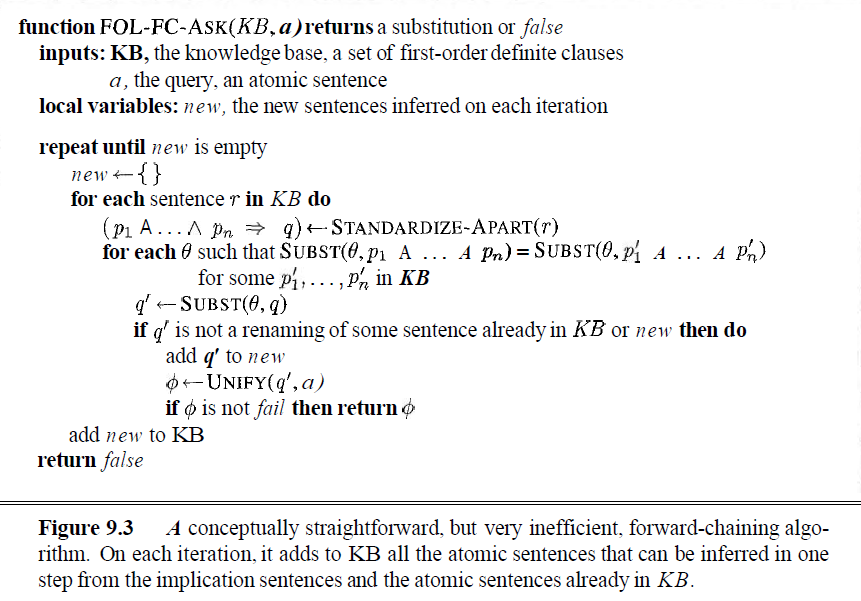

We consider the simple forward-chaining algorithm presented in <em>Figure 9.3</em>. We look at each rule in the knowledge base and see if the premises can be satisfied. This is done by finding a substitution which unifies each of the premise with a clause in the `KB`. If we are able to unify the premises, the conclusion (with the corresponding substitution) is added to the `KB`. This inferencing process is repeated until either the query can be answered or till no new sentences can be added. We test if the newly added clause unifies with the query in which case the substitution yielded by `unify` is an answer to the query. If we run out of sentences to infer, this means the query was a failure.

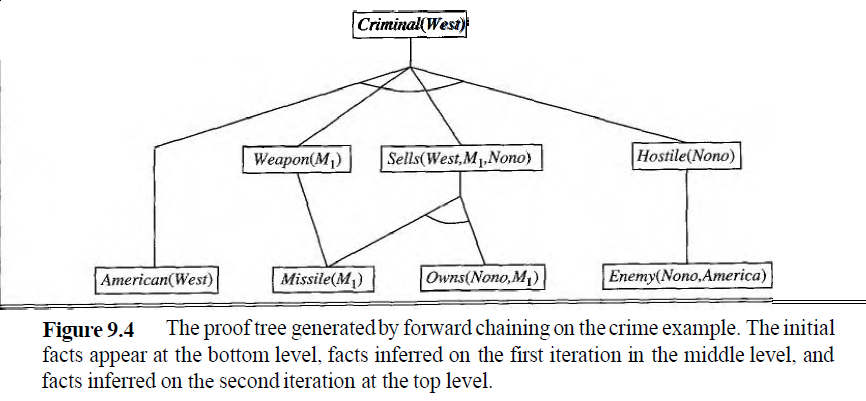

The function `fol_fc_ask` is a generator which yields all substitutions which validate the query.

In [18]:
def fol_fc_ask(kb, alpha):
    """
    [Figure 9.3]
    A simple forward-chaining algorithm.
    """
    # TODO: improve efficiency
    kb_consts = list({c for clause in kb.clauses for c in constant_symbols(clause)})

    def enum_subst(p):
        query_vars = list({v for clause in p for v in variables(clause)})
        for assignment_list in itertools.product(kb_consts, repeat=len(query_vars)):
            theta = {x: y for x, y in zip(query_vars, assignment_list)}
            yield theta

    # check if we can answer without new inferences
    for q in kb.clauses:
        phi = unify_mm(q, alpha)
        if phi is not None:
            yield phi

    while True:
        new = []
        for rule in kb.clauses:
            p, q = parse_definite_clause(rule)
            for theta in enum_subst(p):
                if set(subst(theta, p)).issubset(set(kb.clauses)):
                    q_ = subst(theta, q)
                    if all([unify_mm(x, q_) is None for x in kb.clauses + new]):
                        new.append(q_)
                        phi = unify_mm(q_, alpha)
                        if phi is not None:
                            yield phi
        if not new:
            break
        for clause in new:
            kb.tell(clause)
    return None

Let's find out all the hostile nations. Note that we only told the KB that Nono was an enemy of America, not that it was hostile.

In [16]:
answer = fol_fc_ask(crime_kb, expr('Hostile(x)'))
print(list(answer))

[{x: Nono}]


The generator returned a single substitution which says that Nono is a hostile nation. See how after adding another enemy nation the generator returns two substitutions.

In [17]:
crime_kb.tell(expr('Enemy(JaJa, America)'))
answer = fol_fc_ask(crime_kb, expr('Hostile(x)'))
print(list(answer))

[{x: Nono}, {x: JaJa}]


Note: fol_fc_ask makes changes to the KB by adding sentences to it.

## References

- https://github.com/aimacode/aima-python

